<a href="https://colab.research.google.com/github/smf-9000/kaggle/blob/main/%5B002%5D_tabular_playground_series_jul_2021_%5Bfinal%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%config Completer.use_jedi = False

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imread
import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from statsmodels.nonparametric.smoothers_lowess import lowess


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tabular-playground-series-jul-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-jul-2021/train.csv
/kaggle/input/tabular-playground-series-jul-2021/test.csv


In [ ]:
submission_ex = pd.read_csv('/kaggle/input/tabular-playground-series-jul-2021/sample_submission.csv')
train_df = pd.read_csv('/kaggle/input/tabular-playground-series-jul-2021/train.csv')
test_df = pd.read_csv('/kaggle/input/tabular-playground-series-jul-2021/test.csv')

In [ ]:
def root_mean_squared_log_error(y_true, y_pred):
    msle = tf.keras.losses.MeanSquaredLogarithmicError()
    return K.sqrt(msle(y_true, y_pred)) 

In [ ]:
train_df

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,12.0,167.7
1,2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,9.9,98.9
2,2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,127.1
3,2010-03-10 21:00:00,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2.2,9.7,177.2
4,2010-03-10 22:00:00,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.5,6.4,121.8
...,...,...,...,...,...,...,...,...,...,...,...,...
7106,2010-12-31 20:00:00,9.2,32.0,0.3871,1000.5,811.2,873.0,909.0,910.5,1.3,5.1,191.1
7107,2010-12-31 21:00:00,9.1,33.2,0.3766,1022.7,790.0,951.6,912.9,903.4,1.4,5.8,221.3
7108,2010-12-31 22:00:00,9.6,34.6,0.4310,1044.4,767.3,861.9,889.2,1159.1,1.6,5.2,227.4
7109,2010-12-31 23:00:00,8.0,40.7,0.4085,952.8,691.9,908.5,917.0,1206.3,1.5,4.6,199.8


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7111 entries, 0 to 7110
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date_time               7111 non-null   object 
 1   deg_C                   7111 non-null   float64
 2   relative_humidity       7111 non-null   float64
 3   absolute_humidity       7111 non-null   float64
 4   sensor_1                7111 non-null   float64
 5   sensor_2                7111 non-null   float64
 6   sensor_3                7111 non-null   float64
 7   sensor_4                7111 non-null   float64
 8   sensor_5                7111 non-null   float64
 9   target_carbon_monoxide  7111 non-null   float64
 10  target_benzene          7111 non-null   float64
 11  target_nitrogen_oxides  7111 non-null   float64
dtypes: float64(11), object(1)
memory usage: 666.8+ KB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2247 entries, 0 to 2246
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date_time          2247 non-null   object 
 1   deg_C              2247 non-null   float64
 2   relative_humidity  2247 non-null   float64
 3   absolute_humidity  2247 non-null   float64
 4   sensor_1           2247 non-null   float64
 5   sensor_2           2247 non-null   float64
 6   sensor_3           2247 non-null   float64
 7   sensor_4           2247 non-null   float64
 8   sensor_5           2247 non-null   float64
dtypes: float64(8), object(1)
memory usage: 158.1+ KB


In [ ]:
train_df.isna().sum()

date_time                 0
deg_C                     0
relative_humidity         0
absolute_humidity         0
sensor_1                  0
sensor_2                  0
sensor_3                  0
sensor_4                  0
sensor_5                  0
target_carbon_monoxide    0
target_benzene            0
target_nitrogen_oxides    0
dtype: int64

In [ ]:
test_df.isna().sum()

date_time            0
deg_C                0
relative_humidity    0
absolute_humidity    0
sensor_1             0
sensor_2             0
sensor_3             0
sensor_4             0
sensor_5             0
dtype: int64

### train dataset

In [ ]:
# ################################################################
# for c in train_df.columns:
#     if c != 'date_time':
#         fig = plt.figure(figsize = (15, 5))
#         g = train_df.iloc[:1000,:][c].plot()
#         g.legend([c])

In [ ]:
# ################################################################
# fig = plt.figure(figsize = (30,30))
# ax = fig.gca()
# hist = train_df[train_df.columns.values].hist(bins=150, ax = ax)

### test dataset

In [ ]:
# ################################################################
# for c in test_df.columns:
#     if c != 'date_time':
#         fig = plt.figure(figsize = (15, 5))
#         g = test_df[c].plot()
#         g.legend([c])

In [ ]:
# ################################################################
# fig = plt.figure(figsize = (30,30))
# ax = fig.gca()
# hist = test_df[test_df.columns.values].hist(bins=150, ax = ax)

### feature correlation

In [ ]:
# ################################################################
# corr = train_df.corr()
# fig = plt.figure(figsize = (15,15))
# sns.heatmap(corr, vmax = .8, square = True, annot=True)
# plt.show()

### new features

In [ ]:
# -------------------------------------------------
for df in [train_df, test_df]:
    df['deg_K'] = (df['deg_C'] + 273.15)
    df['deg_x'] = (df['deg_K']**-1)
    df['s_3'] = (df['sensor_3']**-1)
#     del df['deg_C']
    del df['deg_K']
    
    df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')

#     doy = df['date_time'].dt.dayofyear.values
#     df['day_of_y_sin'] = np.sin(doy * (2. * np.pi / 365))
#     df['day_of_y_cos'] = np.cos(doy * (2. * np.pi / 365))
#     hh = df['date_time'].dt.hour.values
#     df['hh_sin'] = np.sin(hh * (2. * np.pi / 24))
#     df['hh_cos'] = np.cos(hh * (2. * np.pi / 24))
    
#     df['time'] = df['date_time'].astype(np.int64)//10**9
    df['hh'] = df['date_time'].dt.hour.values
    df['day_of_w'] = df['date_time'].dt.dayofweek.values
    df['weekend'] = df['day_of_w'].apply(lambda x: 1 if (x>4)  else 0)
    df['saturday'] = df['day_of_w'].apply(lambda x: 1 if (x == 5)  else 0)
    df['sunday'] = df['day_of_w'].apply(lambda x: 1 if (x == 6)  else 0)
#     df['month'] = df['date_time'].dt.month.values

    # ----------------------------------
    mm = df['date_time'].dt.month.values
    df['mm_cos'] = np.cos(mm * (2. * np.pi / 12))

    ww = df["date_time"].dt.isocalendar().week.values
    df['ww_cos'] = np.cos((ww) * (2. * np.pi / 52)) # (ww + 2)

    dd = df['date_time'].dt.dayofyear.values
    df['dd_cos'] = np.cos((dd) * (2. * np.pi / 365))
    for _d in [10, 20, 30]:
        df['dd_cos_plus_' + str(_d)] = np.cos((dd + _d) * (2. * np.pi / 365))
        df['dd_cos_minus_' + str(_d)] = np.cos((dd - _d) * (2. * np.pi / 365))
    
    hh = df['date_time'].dt.hour.values
    df['hh_sin'] = np.sin((hh-12) * (2. * np.pi / 24))
    # ----------------------------------
    
    df["working_h"] =  df["hh"].isin(np.arange(8, 21, 1)).astype("int")

    df["SMC"] = (df["absolute_humidity"] * 100) / df['relative_humidity']

    df['hm_1'] = ((df['absolute_humidity'].values <= 0.25)).astype(int)

#     lag_features = ['deg_C', 'relative_humidity', 'absolute_humidity', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']
#     lags = [3, 6, 9, 12]
#     for feature in lag_features:
#         for lag in lags:
#             df[feature + '_lag_' + str(lag)] = df[feature] - df[feature].shift(periods=lag, fill_value=0)

# -------------------------------------------------

### feature correlation

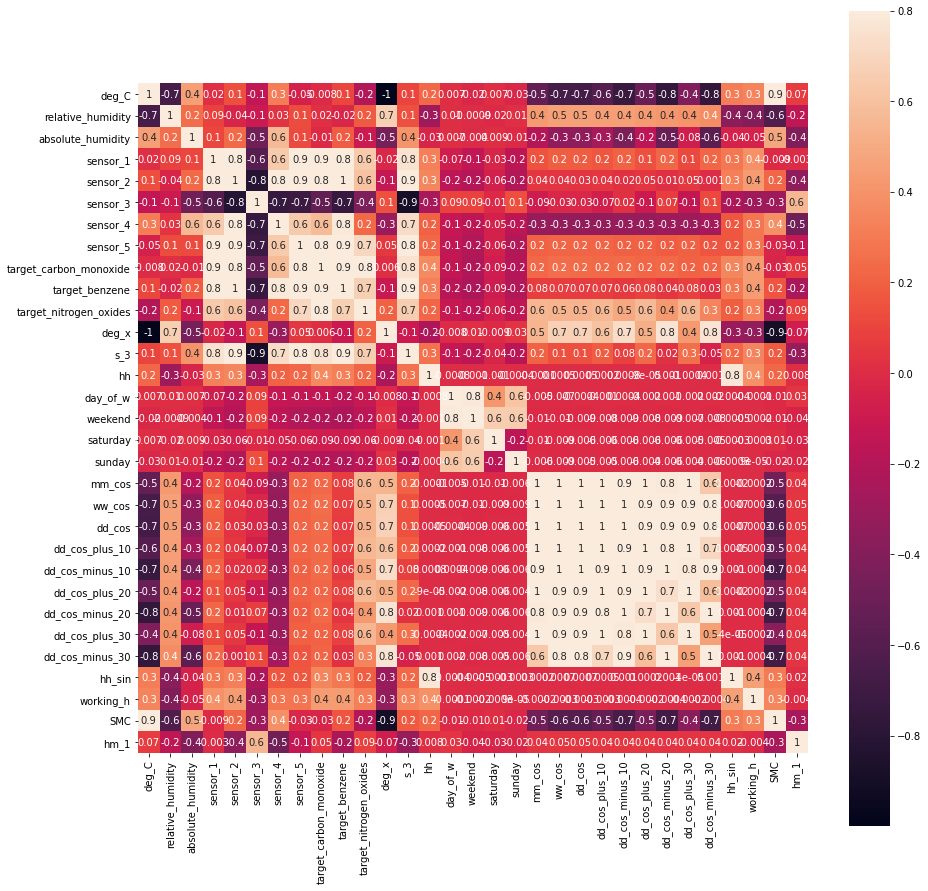

In [ ]:
# ################################################################
corr = train_df.corr()
fig = plt.figure(figsize = (15,15))
sns.heatmap(corr, vmax = .8, square = True, annot=True, fmt='.1g')
plt.show()

In [ ]:
targets_df = train_df[["target_carbon_monoxide","target_benzene","target_nitrogen_oxides"]].copy()
train_df.drop(["target_carbon_monoxide","target_benzene","target_nitrogen_oxides"], axis=1, inplace=True)  

### BayesianOptimization

In [ ]:
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_log_error
import warnings
from sklearn.model_selection import KFold

In [ ]:
def bayesion_opt_lgbm(X, y, init_points = 3, n_iter = 7, random_state = 42, seed = 42, _folds = 5, bo_verbose = 1):
    dtrain = lgb.Dataset(data = X, label = y)
    print('no_of_folds: ', _folds)
    folds = KFold(_folds, shuffle = False)

    def rmsle_score(preds, dtrain):
        labels = dtrain.get_label()
        tmp = np.array(preds)
        if (tmp < 0).sum() > 0:
            return 'rmsle', -10**3, True
        return 'rmsle', -mean_squared_log_error(labels, preds)**0.5, True

    def hyp_lgbm(learning_rate, 
                 num_leaves, 
                 max_depth, 
                 n_estimators):

        params = {'application':'regression', 'metric':'rmsle_score', 'force_col_wise':True, 'verbose': -1}
        params['learning_rate'] = learning_rate
        params['num_leaves'] = int(round(num_leaves))
        params['max_depth'] = int(round(max_depth))
        params['n_estimators'] = int(round(n_estimators))
        cv_results = lgb.cv(
            params, 
            dtrain, 
            folds=folds.split(X), 
#             nfold = _folds, 
            seed = random_state, 
            stratified = False, 
            verbose_eval = None, 
            feval = rmsle_score)

        return np.max(cv_results['rmsle-mean'])
    pds = {
        'learning_rate': (0.001, 0.3),
        'num_leaves': (2, 100),
        'max_depth': (-1, 50),
        'n_estimators': (50, 1000)
        }

    optimizer = BayesianOptimization(hyp_lgbm, pds, random_state = random_state, verbose = bo_verbose)

    # n_iter: How many steps of bayesian optimization you want to perform. The more steps the more likely to find a good maximum you are.
    # init_points: How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.
    optimizer.maximize(init_points = init_points, n_iter = n_iter)

    return optimizer.max


In [ ]:
# warnings.filterwarnings("ignore")

# X, y, hm_indices = None, None, None

# lgbm = LGBMRegressor()
# for _target in ['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']:
#     if _target != 'target_benzene':
#         X = np.array(train_df[list(test_df.columns.values)[1:]].values, dtype='float32')
#         hm_indices = train_df[train_df['hm_1'] == 1].index.values
#         X = np.delete(X, hm_indices, axis=0)
#         y = np.squeeze(np.array(targets_df[[_target]].values, dtype='float32'))
#         y = np.delete(y, hm_indices, axis=0)
#     else:
#         X = np.array(train_df[list(test_df.columns.values)[1:]].values, dtype='float32')
#         y = np.squeeze(np.array(targets_df[[_target]].values, dtype='float32'))

#     data = bayesion_opt_lgbm(X, y, init_points = 30, n_iter = 70, _folds = 5, bo_verbose = 2, random_state = 37)  #init_points=random, n_iter=bayesian
#     for k, v in data['params'].items():
#         if k in ['bagging_freq', 'max_depth', 'n_estimators', 'num_leaves']:
#             data['params'][k] = int(round(v))
#     print('params_' + str(_target) + ' =', data['params'])

### LGBMRegressor

In [ ]:
lgbm_regs = {}

params_target_carbon_monoxide = {'learning_rate': 0.09207951698283784, 'max_depth': 4, 'n_estimators': 700, 'num_leaves': 45}
params_target_benzene = {'learning_rate': 0.022010449497560453, 'max_depth': 0, 'n_estimators': 368, 'num_leaves': 81}
params_target_nitrogen_oxides = {'learning_rate': 0.09207951698283784, 'max_depth': 4, 'n_estimators': 700, 'num_leaves': 45}



lgbm_regs['target_carbon_monoxide'] = LGBMRegressor(**params_target_carbon_monoxide)

lgbm_regs['target_benzene'] = LGBMRegressor(**params_target_benzene)
# reg_sqrt=True
lgbm_regs['target_nitrogen_oxides'] = LGBMRegressor(**params_target_nitrogen_oxides)

xgbr = XGBRegressor(objective = 'reg:squarederror')

### postprocessing

In [ ]:
def postprocessing(pred, df):
    _hh = df['hh'].values
    _dow = df['day_of_w'].values
    _hm = df['hm_1'].values
    Mlr = {}
    Mrl = {}
    C = [0 for _ in range(len(pred))]
    D = [0 for _ in range(len(pred))]
    for i in range(len(pred)):
        j = len(pred) - 1 - i
        hl = _hh[i]
        dl = _dow[i]
        hml = _hm[i]
        hr = _hh[j]
        dr = _dow[j]
        hmr = _hm[j]
        curr_kl = str(hl) + '_' + str(dl)
        curr_kr = str(hr) + '_' + str(dr)
        if hml != 1:
            if curr_kl not in Mlr:
                Mlr[curr_kl] = []
            Mlr[curr_kl].append(pred[i])
        else:
            if curr_kl in Mlr:
                if len(Mlr[curr_kl]) > 1:
                    D[i] += sum(Mlr[curr_kl][-2:])
                    C[i] += 2
                    pass
                else:
                    D[i] += Mlr[curr_kl][0]
                    C[i] += 1
        if hmr != 1:
            if curr_kr not in Mrl:
                Mrl[curr_kr] = []
            Mrl[curr_kr].append(pred[j])
        else:
            if curr_kr in Mrl:
                if len(Mrl[curr_kr]) > 1:
                    D[j] += sum(Mrl[curr_kr][-2:])
                    C[j] += 2
                    pass
                else:
                    D[j] += Mrl[curr_kr][0]
                    C[j] += 1
    
#     print(C)
    for i in range(len(pred)):
        if C[i] != 0:
            pred[i] = D[i] / C[i]

### submission

In [ ]:
submit = True

submit:  target_benzene
submit:  target_carbon_monoxide
submit:  target_nitrogen_oxides


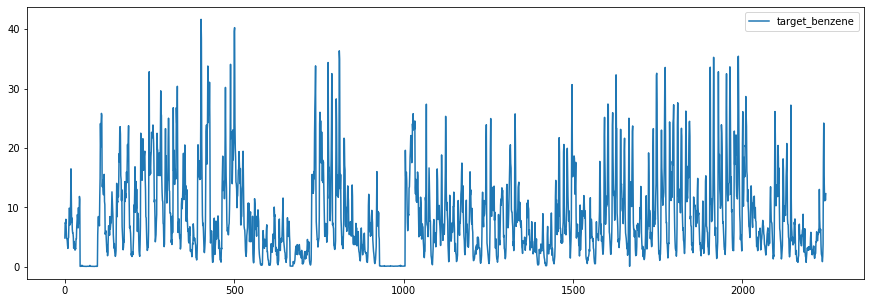

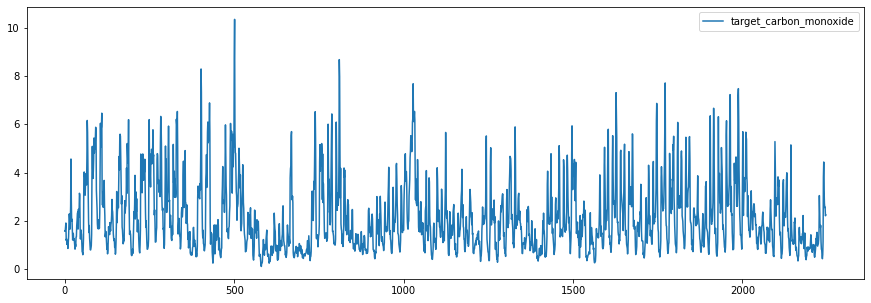

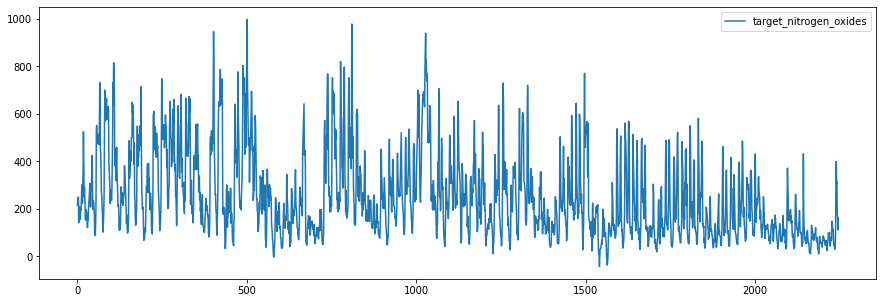

In [ ]:
submission = submission_ex.copy()

for _target in ['target_benzene', 'target_carbon_monoxide', 'target_nitrogen_oxides']:
    X = np.array(train_df[list(test_df.columns.values)[1:]].values, dtype='float32')
    hm_indices = train_df[train_df['hm_1'] == 1].index.values
    y = np.squeeze(np.array(targets_df[[_target]].values, dtype='float32'))
    X_test = np.array(test_df.iloc[:,1:].values, dtype='float32')

    if not submit:
        split_train = 5500
        X, X_val = X[:split_train], X[split_train:]
        y, y_val = y[:split_train], y[split_train:]

        XX = X
        if _target != 'target_benzene':
            X = np.delete(X, [e for e in hm_indices if e < split_train], axis=0)
            y = np.delete(y, [e for e in hm_indices if e < split_train], axis=0)

        lgbm_regs[_target].fit(X, y)
        p1 = lgbm_regs[_target].predict(X_val)
        
        
#         lgbm_regs[_target].booster_.feature_importance()
#         fea_imp_ = pd.DataFrame({'cols':list(test_df.columns.values)[1:], 'fea_imp':lgbm_regs[_target].feature_importances_})
#         ff_ii = fea_imp_.loc[fea_imp_['fea_imp'] > 0].sort_values(by=['fea_imp'], ascending = False)
#         print(ff_ii)

        if _target != 'target_benzene':
            postprocessing(p1, train_df.iloc[split_train:,:])

        print('target: ', _target)
        print('=================================')
        print('rmsle: ', root_mean_squared_log_error(y_val, p1))

        fig = plt.figure(figsize = (30, 10))
        g = targets_df.iloc[split_train:,:].reset_index()[_target].plot()
        tmp_col = pd.DataFrame(data=p1, columns=['tmp'])
        g = tmp_col['tmp'].plot(alpha = 0.7)
        g.legend([_target])
    else:
        print('submit: ', _target)

        if _target != 'target_benzene':
            X = np.delete(X, hm_indices, axis=0)
            y = np.delete(y, hm_indices, axis=0)

        lgbm_regs[_target].fit(X, y)
        p1 = lgbm_regs[_target].predict(X_test)

        if _target != 'target_benzene':
            postprocessing(p1, test_df)

        fig = plt.figure(figsize = (15, 5))
        tmp_col = pd.DataFrame(data=p1, columns=[_target])
        g = tmp_col[_target].plot()
        g.legend([_target])

        submission[_target] = p1

In [ ]:
submission.to_csv('submission.csv', index=False)

test = pd.read_csv('submission.csv')
test.tail()

,date_time,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
2242,2011-04-04 10:00:00,2.724882,12.606339,314.110320
2243,2011-04-04 11:00:00,2.553802,11.113193,179.257739
2244,2011-04-04 12:00:00,2.566828,12.311498,158.620093
2245,2011-04-04 13:00:00,2.211682,11.212251,111.316998
2246,2011-04-04 14:00:00,2.245753,12.321099,161.150101


In [ ]:
test.head()

,date_time,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2011-01-01 00:00:00,1.573790,4.862605,216.017672
1,2011-01-01 01:00:00,1.567035,7.434515,227.926807
2,2011-01-01 02:00:00,1.726856,7.333229,236.345797
3,2011-01-01 03:00:00,1.911163,8.010728,250.427360
4,2011-01-01 04:00:00,1.191686,6.372252,141.626016
